In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import pandas as pd

sys.path.append('..')

import torch
from torch.utils.data import DataLoader
from sklearn import datasets
from sklearn.model_selection import train_test_split

# DEID libraries
from gojo import core
from gojo import deepl
from gojo import util
from gojo import plotting

In [2]:
# load test dataset (Wine)
wine_dt = datasets.load_wine()

# create the target variable. Classification problem 0 vs rest
# to see the target names you can use wine_dt['target_names']
y = (wine_dt['target'] == 1).astype(int)  
X = wine_dt['data']

# standarize input data
std_X = util.zscoresScaling(X)

# split Xs and Ys in training and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    std_X, y, train_size=0.8, random_state=1997, shuffle=True,
    stratify=y
)
X_train.shape, X_valid.shape, '%.3f' % y_train.mean(),  '%.3f' % y_valid.mean()

((142, 13), (36, 13), '0.401', '0.389')

In [3]:
# create the dataloaders
train_dl = DataLoader(
    deepl.loading.TorchDataset(X=X_train, y=y_train), 
    batch_size=16, shuffle=True)

valid_dl = DataLoader(
    deepl.loading.TorchDataset(X=X_valid, y=y_valid), 
    batch_size=X_valid.shape[0], shuffle=False)

In [4]:
# create a basic FFN
model = deepl.ffn.createSimpleFFNModel(
    in_feats=X_valid.shape[1],
    out_feats=1,
    layer_dims=[20],
    layer_activation=torch.nn.ELU(),
    output_activation=torch.nn.Sigmoid()
)
model

Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
)

In [5]:
output = deepl.fitNeuralNetwork(
    deepl.iterSupervisedEpoch,
    model=model,
    train_dl=train_dl,
    valid_dl=valid_dl,
    n_epochs=50,
    loss_fn=torch.nn.BCELoss(),
    optimizer_class=torch.optim.Adam,
    optimizer_params={'lr': 0.001},
    device='mps',
    metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5)
)


Epoch (1) ============================================ 
	 (train) loss (mean): 0.67844
	 (train) loss (std): 0.05737
	 (train) accuracy: 0.60563
	 (train) balanced_accuracy: 0.65614
	 (train) precision: 0.50485
	 (train) recall: 0.91228
	 (train) sensitivity: 0.91228
	 (train) specificity: 0.40000
	 (train) negative_predictive_value: 0.87179
	 (train) f1_score: 0.65000
	 (train) auc: 0.65614

	 (valid) loss (mean): 0.61964
	 (valid) loss (std): 0.00000
	 (valid) accuracy: 0.69444
	 (valid) balanced_accuracy: 0.73701
	 (valid) precision: 0.56522
	 (valid) recall: 0.92857
	 (valid) sensitivity: 0.92857
	 (valid) specificity: 0.54545
	 (valid) negative_predictive_value: 0.92308
	 (valid) f1_score: 0.70270
	 (valid) auc: 0.73701


Epoch (2) ============================================ 
	 (train) loss (mean): 0.64198
	 (train) loss (std): 0.06253
	 (train) accuracy: 0.67606
	 (train) balanced_accuracy: 0.71785
	 (train) precision: 0.55789
	 (train) recall: 0.92982
	 (train) sensitivity: 0.

In [6]:
output.keys()

dict_keys(['train', 'valid'])

In [7]:
train_info = output['train']
valid_info = output['valid']


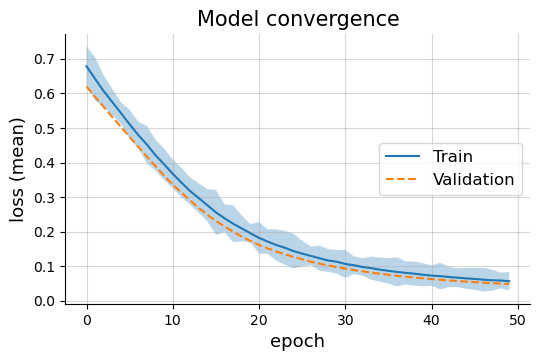

In [8]:
plotting.linePlot(
    train_info, valid_info,
    x='epoch', y='loss (mean)', err='loss (std)',
    legend_labels=['Train', 'Validation'],
    title='Model convergence',
    ls=['solid', 'dashed'],
    style='default', legend_pos='center right'
    
)


In [10]:
print(util.io.serialize(model, 'test_normal.joblib', backend='joblib'))
print(util.io.serialize(model, 'test_gzip.joblib', backend='joblib_gzip'))
print(util.io.serialize(model, 'test_normal.pkl', backend='pickle'))
print(util.io.serialize(model, 'test_gzip.pkl', backend='pickle_gzip'))

/Users/fgarcia/Library/CloudStorage/OneDrive-FUNDACIOACE/Escritorio/GitHub/Machine-Learning-Tools-V2/notebook/test_normal.joblib
/Users/fgarcia/Library/CloudStorage/OneDrive-FUNDACIOACE/Escritorio/GitHub/Machine-Learning-Tools-V2/notebook/test_gzip.joblib.gz
/Users/fgarcia/Library/CloudStorage/OneDrive-FUNDACIOACE/Escritorio/GitHub/Machine-Learning-Tools-V2/notebook/test_normal.pkl
/Users/fgarcia/Library/CloudStorage/OneDrive-FUNDACIOACE/Escritorio/GitHub/Machine-Learning-Tools-V2/notebook/test_gzip.pkl.gz


In [11]:
print(util.io.load('test_normal.joblib', backend='joblib'))
print(util.io.load('test_gzip.joblib.gz', backend='joblib_gzip'))
print(util.io.load('test_normal.pkl', backend='pickle'))
print(util.io.load('test_gzip.pkl.gz', backend='pickle_gzip'))

Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
)
Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
)
Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
)
Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
)


In [12]:
model = util.io.load('test_gzip.pkl.gz', backend='pickle_gzip')

In [13]:
model()

Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
)

In [18]:
model = model.eval()

In [14]:
for X, y in valid_dl:
    break

In [15]:
X.shape

torch.Size([36, 13])

In [16]:
y.shape

torch.Size([36, 1])

In [20]:
y_hat = model(X.to(device='mps'))

In [21]:
y_hat = y_hat.detach().cpu().numpy()
y_hat.shape

(36, 1)

In [22]:
y = y.cpu().numpy()
y.shape

(36, 1)

In [24]:
((y_hat.reshape(-1) > 0.5).astype(int) == y.reshape(-1)).mean()

1.0

In [ ]:
assert False

In [ ]:
import inspect

In [ ]:
inspect.isclass(valid_info)

In [ ]:
import matplotlib.pyplot as plt

def linePlot(*dfs, x: str, y: str, err: str = None, err_alpha: float = 0.3, 
             labels: list = None, figsize: tuple = (6, 3.5), dpi: int = 100, 
             style: str = 'ggplot', legend_pos: str = 'upper right', 
             legend_size: int = 12, colors: list = None, grid_alpha: float = 0.5,
             xlabel_size: float or int = 13, ylabel_size: float or int = 13,
             title: str = '', title_size: int or float = 15, save: str = None,
             save_kw: dict = None, show: bool = True
            ):
    """ Description """
    # check input data types
    
    for df in dfs:
        # check dataframe input types
        # check x, y, and err variables
        pass 
    
    if labels is None:
        labels = ['(%d)' % (i+1) for i in range(len(dfs))]
    
    # check number of labels and number of dfs
    # check the lenght of the colors
    
    # plot information
    with plt.style.context(style):
        fig, ax = plt.subplots(figsize=figsize)
        fig.set_dpi(dpi)
        
        for i, (label, df) in enumerate(zip(labels, dfs)):
            color = None if colors is None else colors[i]
            
            ax.plot(
                df[x].values, df[y].values, label=label,
                color=color)
            
            if err is not None:
                ax.fill_between(
                    df[x].values, 
                    df[y].values + df[err].values,
                    df[y].values - df[err].values,
                    alpha=err_alpha)
            
        # figure layout
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(alpha=grid_alpha)
        ax.legend(loc=legend_pos, prop=dict(size=legend_size))
        ax.set_xlabel(x, size=xlabel_size)
        ax.set_ylabel(y, size=ylabel_size)
        ax.set_title(title, size=title_size)
        
        # save figure if specified
        if save:
            save_kw = {} if save_kw is None else save_kw
            plt.savefig(save, **save_kw)
            
        if show:
            plt.show()
        
linePlot(train_info, valid_info, x='epoch', y='loss (mean)', labels=['Train', 'Validation'], err='loss (std)', title='FOO')

In [ ]:
valid_info['epoch'].values

In [ ]:
valid_info

In [ ]:
train_info